# On the difference between BR and NBR (in potential games)

### Irreducibility

- The NBR dynamics is irreducible, i.e., from every configuration it can visit every other configuration, even in the small noise limit $\eta \to +\infty$.
- The BR is not irreducible. Transitions are allowed only if the potential does not decrease along the trajectory.

### Invariant distribution
- As a consequence of its irreducibility, the NBR dynamics admits a unique invariant distribution whose is support is the whole space of configurations $\mathcal{X}$. The invariant distribution is

$$
\pi_x = \frac{e^{\eta \Phi(x)}}{Z_\eta}, \quad Z_\eta = \sum_{y\in \mathcal{X}} e^{\eta \Phi(y)}.
\tag{1}
$$

- The BR converges almost surely in finite time to a sink component of Nash equilibria (called recurrent equilibria, indicated by $\mathcal{N}_\infty$). However, $\mathcal{N}_\infty$ may in general contain multiple disconnected sets of Nash equilibria, and which one is selected depends on the initial condition and on the realization of the Markov process. Thus, the BR dynamics may admit multiple invariant distributions, all of them having support on $\mathcal{N}_\infty$.

### Nash equilibria selection
- As $\eta \to +\infty$, the invariant distribution of the NBR dynamics tends to a uniform probability distribution over $\text{argmax} \ \Phi$, i.e., for large times the NBR dynamics spends a fraction 1 of the total time in global maximizers of the potential. 

- For large times, the BR dynamics spends a fraction 1 of the total time in $\mathcal{N}_\infty$ (in which recurrent equilibria depends on the initial condition and on the realization of the dynamics). 

- In general $\mathcal{N}_\infty \neq \text{argmax} \ \Phi$. The only property that can be proven is that $\text{argmax} \ \Phi \subseteq \mathcal{N}_\infty$. 

**Take-home message**: the noisy best reponse with $\eta \to +\infty$ selects a subset of the equilibria selected by the BR dynamics. But the notion of "selecting an equilibrium" depends on the considered dynamics, in the sense that the BR dynamics gets trapped in $\mathcal{N}_\infty$, while the NBR spends almost of the time in the maximizers of the potential, but can leave the set of the equilibria because of its irreducibility.

## Some examples

### Majority game on complete graph: $\text{argmax} \ \Phi = \mathcal{N}_\infty$.

The game admits two Nash equilibria, 'all ones' and 'all zeros', both of them belonging to $\mathcal{N}_\infty$ and both of them global maximizers of the potential (in the majority game the potential counts the links between agents playing the same action). 

Thus: 
- the BR dynamics will converge almost surely in finite time to one of the two configurations (which one depends crucially on the initial condition);
- The NBR with large $\eta$, observed for large times, will spent fraction 1/2 of time in 'all ones' and 1/2 in 'all zeros', indepedently on the initial condition.

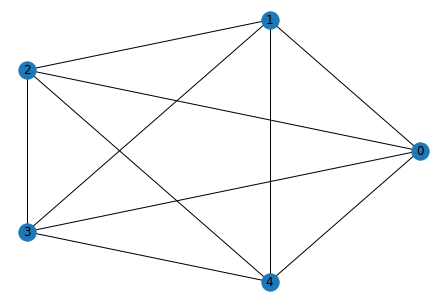

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

G = nx.complete_graph(5)

pos = nx.circular_layout(G)
nx.draw(G, pos=pos, with_labels=True)

In [2]:
# Define the majority game as a network conrdination game

# number of nodes in G = number of players in the game
n_players = len(G)
# utility values
a = 1
b = 1
c = 0
d = 0
# utility matrix for the 2x2 coordination game
phi = np.array([[a,d],
                [c,b]])
# the potential function of the 2x2 coordination game
pot = np.array([[a-c,0],
                [0,b-d]])
# inverse noise parameter
eta = 3
# available actions
actions = [0,1]
n_actions = len(actions)
# adjacency matrix
W = nx.convert_matrix.to_numpy_matrix(G)

def utility(player, x, phi):
    result = 0
    for other_player in G.neighbors(player):
         result += phi[x[player], x[other_player]]
    return result

In [3]:
# Define the noisy best response dynamics

# Initialize transition rates matrix
n_config = n_actions**n_players
Lambda = sp.sparse.lil_matrix((n_config,n_config))

# Number of actions for each player
n_states =tuple(n_actions for _ in range(n_players))

# Fill transition rates matrix
for x_id in range(n_config):
    x = np.unravel_index(x_id,shape=n_states)
    x = np.array(x)
    for player in range(n_players):
        # compute utilities gained by `player` for each of its possible actions
        # while the other players are in the current configuration x
        utilities = np.zeros(n_actions)
        for action in actions:
            y = np.array(x)
            y[player] = action
            utilities[action] = utility(player,y,phi)
        exp_utilities = np.exp(eta*utilities)
        for action in actions:
            if action == x[player]:
                continue
            y = np.array(x)
            y[player] = action
            y_id = np.ravel_multi_index(tuple(y), dims = n_states)
            Lambda[x_id, y_id] += exp_utilities[action] / np.sum(exp_utilities)

In [4]:
# Simulate the continuous time Markov chain with 2nd approach: local clocks
w = np.sum(Lambda, axis=1)

# reshape w
w = np.array(w.T)[0]
for x, weight in enumerate(w):
    # add selfloop if a configuration is a sink, otherwise D is not well defined
    if weight == 0:
        Lambda[x,x] = 1
        w[x] = 1
D = np.diag(w)
P = np.linalg.inv(D) @ Lambda

# number of iterations
n_steps = 1000000

states = np.zeros(n_steps, dtype=int)
# initial configuration
x = np.random.choice(actions, size = n_players)
x_id = np.ravel_multi_index(tuple(x), dims = n_states)
states[0] = x_id

transition_times = np.zeros(n_steps)
t_next = -np.log(np.random.rand())/w[states[0]]

P_cum = np.cumsum(P, axis=1)

for i in range(1,n_steps):
    states[i] = np.argwhere(P_cum[states[i-1]] > np.random.rand())[0]
    transition_times[i] = transition_times[i-1] + t_next
    t_next = -np.log(np.random.rand())/w[states[i]]

In [5]:
# compute frequencies
intervals = np.diff(transition_times, n=1, append = transition_times[-1] + t_next)
frequencies = np.zeros(n_config)

for node in range(n_config):
    visits = np.argwhere(states == node)
    frequencies[node] = np.sum(intervals[visits])/(transition_times[-1] + t_next)
print("Empirical frequencies:", frequencies, "\n")

Empirical frequencies: [5.06495351e-01 3.09745533e-06 3.15121111e-06 7.55485806e-09
 3.09589750e-06 7.82823004e-09 8.04849505e-09 7.51367858e-09
 3.09778605e-06 7.34705543e-09 7.16072460e-09 6.47525037e-09
 6.83069599e-09 7.16410469e-09 7.00253551e-09 2.98808191e-06
 3.09174432e-06 8.34751632e-09 7.29741388e-09 7.62391226e-09
 7.62391965e-09 6.71405330e-09 8.13497651e-09 3.02553445e-06
 7.82250153e-09 7.49939845e-09 7.63393698e-09 3.03801491e-06
 6.60676563e-09 3.03422373e-06 3.03295051e-06 4.93473848e-01] 



As expected, the NBR dynamics spends almost 1/2 of the time on the first configuration, 1/2 on the last configuration (the consensus configurations), and 0 in the other configurations.

**Remark**: if the value of $\eta$ is increased, also the number of steps of the simulation must increase to observe the relaxation to the invariant distribution.

The BR dynamics is much easier. Let us plot two examples of trajectories.

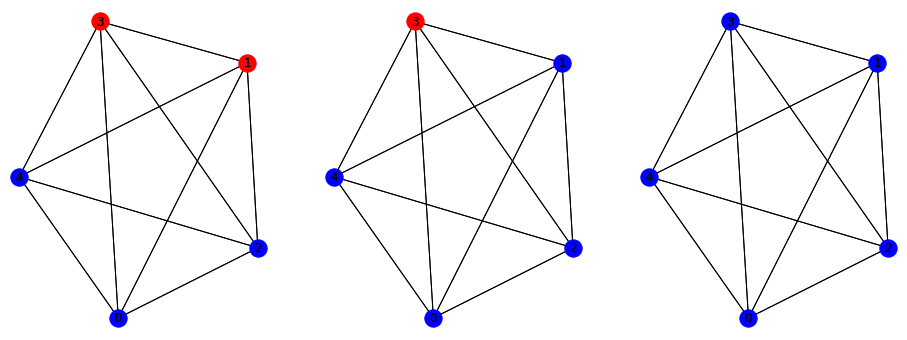

In [6]:
fig = plt.figure(figsize=(16,6))

G = nx.complete_graph(5)
n_nodes = G.number_of_nodes()
pos = nx.spring_layout(G) 

# plot initial condition
x = np.array([1,0,1,0,1])

plt.subplot(1,3,1)
nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==0).T[0].tolist(),
        node_color = 'r')
nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==1).T[0].tolist(),
        node_color = 'b')

x = np.array([1,1,1,0,1])

plt.subplot(1,3,2)
nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==0).T[0].tolist(),
        node_color = 'r')
nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==1).T[0].tolist(),
        node_color = 'b')

x = np.ones(n_nodes)

plt.subplot(1,3,3)
nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==0).T[0].tolist(),
        node_color = 'r')
nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==1).T[0].tolist(),
        node_color = 'b')

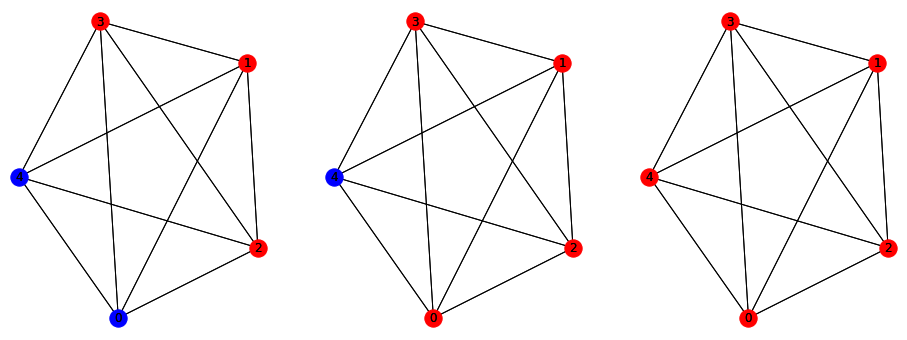

In [7]:
fig = plt.figure(figsize=(16,6))

# plot another initial condition
x = np.array([1,0,0,0,1])

plt.subplot(1,3,1)
nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==0).T[0].tolist(),
        node_color = 'r')
nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==1).T[0].tolist(),
        node_color = 'b')

x = np.array([0,0,0,0,1])

plt.subplot(1,3,2)
nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==0).T[0].tolist(),
        node_color = 'r')
nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==1).T[0].tolist(),
        node_color = 'b')

x = np.zeros(n_nodes)

plt.subplot(1,3,3)
nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==0).T[0].tolist(),
        node_color = 'r')
nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==1).T[0].tolist(),
        node_color = 'b')

Depending on whether there are more zeros or ones the dynamics will converge to one of the two consensus, and will remain there forever. The empirical frequencies thus converge to $\pi = \delta^{(i)}$, where $i$ is either $(0,0,0,0,0)$ or $(1,1,1,1,1)$.

### Majority game on barbell graph ($n \ge 3$): $\text{argmax} \ \Phi \subset \mathcal{N}_\infty$

The game admits four Nash equilibria: 'all ones', 'all zeros', and 'all zeros/ones in first complete subgraph and all ones/zeros in the second complete graph'.

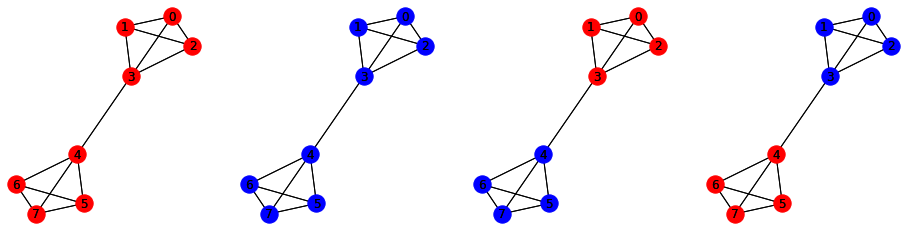

In [8]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

fig = plt.figure(figsize=(16,4))

G = nx.barbell_graph(4,0)
n_nodes = G.number_of_nodes()
pos = nx.spring_layout(G) 

# plot first Nash equilibrium
x = np.zeros(n_nodes)

plt.subplot(1,4,1)
nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==0).T[0].tolist(),
        node_color = 'r')
nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==1).T[0].tolist(),
        node_color = 'b')

# plot second Nash equilibrium
x = np.ones(n_nodes)

plt.subplot(1,4,2)
nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==0).T[0].tolist(),
        node_color = 'r')
nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==1).T[0].tolist(),
        node_color = 'b')

# plot third Nash equilibrium
x = np.ones(n_nodes)
x[0:int(n_nodes/2)] = np.zeros(int(n_nodes/2))

plt.subplot(1,4,3)
nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==0).T[0].tolist(),
        node_color = 'r')
nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==1).T[0].tolist(),
        node_color = 'b')

# plot fourth Nash equilibrium
x = np.ones(n_nodes)
x[int(n_nodes/2):n_nodes] = np.zeros(int(n_nodes/2))

plt.subplot(1,4,4)
nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==0).T[0].tolist(),
        node_color = 'r')
nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==1).T[0].tolist(),
        node_color = 'b')

- The former two equilibria are global maximizers of the potential, the latter two are not. 
- All of them belong to $\mathcal{N}_\infty$ and no links in the transition graph exist between these four equilibria configurations under the best response dynamics. 
- Thus, the BR dynamics will converge to one of the equilibria and will be stuck from there on. Instead, the NBR (with large $\eta$ and large observation time) will spent 1/2 of the time in each of the consensus configurations, and a vanishing time in the other two equilibria.

### Minority game on complete graph (odd $n$): $\mathcal{N}_\infty$ is a connected set of equilibria.

The game admits many Nash equilibria, that can be distinguished in two classes: the class in which $(n-1)/2$ players play the first strategy, and $(n+1)/2$ players play the second strategy, and the symmetric configurations. 

All these equilibria are global maximizers of the potential, all of them belong to $\mathcal{N}_\infty$ and represent a connected component.

Thus, the BR dynamics will converge to this set of equilibria and continue to move between these configurations. The NBR dynamics will converge in distribution to a uniform distribution of probability on these equilibria, but eventually will hit also the other configurations.

An example of trajectory of the BR dynamics is shown below.

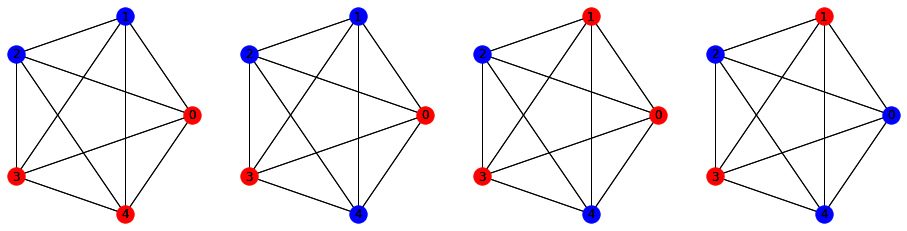

In [9]:
fig = plt.figure(figsize=(16,4))

G = nx.complete_graph(5)
n_nodes = G.number_of_nodes()
pos = nx.circular_layout(G) 

# plot first Nash equilibrium
x = np.array([0,1,1,0,0])

plt.subplot(1,4,1)
nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==0).T[0].tolist(),
        node_color = 'r')
nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==1).T[0].tolist(),
        node_color = 'b')

# plot second Nash equilibrium
x = np.array([0,1,1,0,1])

plt.subplot(1,4,2)
nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==0).T[0].tolist(),
        node_color = 'r')
nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==1).T[0].tolist(),
        node_color = 'b')

# plot third Nash equilibrium
x = np.array([0,0,1,0,1])

plt.subplot(1,4,3)
nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==0).T[0].tolist(),
        node_color = 'r')
nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==1).T[0].tolist(),
        node_color = 'b')

# plot fourth Nash equilibrium
x = np.array([1,0,1,0,1])

plt.subplot(1,4,4)
nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==0).T[0].tolist(),
        node_color = 'r')
nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==1).T[0].tolist(),
        node_color = 'b')

### Minority game on a line ($n=4$): $\mathcal{N}_\infty \subset \mathcal{N}$.

Each Nash equilibrium satisfies the condition that $x_1 \neq x_2$, $x_4 \neq x_3$, otherwise players $1$ and $4$ are not playing best-response.

The game admits $4$ Nash equilibria:

- (0,1,0,1);
- (1,0,1,0);
- (0,1,1,0);
- (1,0,0,1);

Let us plot these configuration

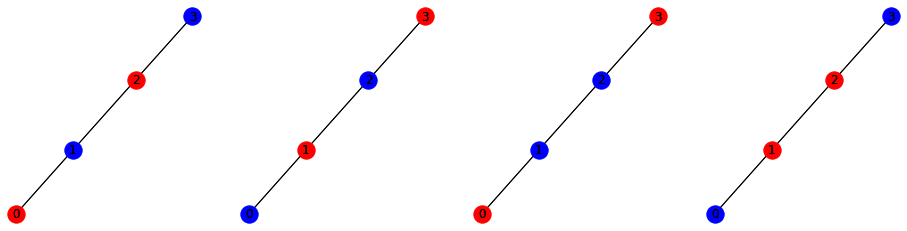

In [10]:
fig = plt.figure(figsize=(16,4))

G = nx.Graph()
G.add_edges_from([(0,1),(1,2),(2,3)])
n_nodes = G.number_of_nodes()
pos = nx.spring_layout(G)

# plot first Nash equilibrium
x = np.array([0,1,0,1])

plt.subplot(1,4,1)
nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==0).T[0].tolist(),
        node_color = 'r')
nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==1).T[0].tolist(),
        node_color = 'b')

# plot second Nash equilibrium
x = np.array([1,0,1,0])

plt.subplot(1,4,2)
nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==0).T[0].tolist(),
        node_color = 'r')
nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==1).T[0].tolist(),
        node_color = 'b')

# plot third Nash equilibrium
x = np.array([0,1,1,0])

plt.subplot(1,4,3)
nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==0).T[0].tolist(),
        node_color = 'r')
nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==1).T[0].tolist(),
        node_color = 'b')

# plot fourth Nash equilibrium
x = np.array([1,0,0,1])

plt.subplot(1,4,4)
nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==0).T[0].tolist(),
        node_color = 'r')
nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==1).T[0].tolist(),
        node_color = 'b')

- The first two configurations belong to $\mathcal{N}_\infty$. Indeed, both the equilibria are strict (i.e., each player has a unique best-response to this configuration) and thus are sinks for the best response dynamics. 
- They also maximize the potential, which for the minority game is the number of links between agents playing a different strategy.

- The latter two equilibria do not belong to $\mathcal{N}_\infty$, i.e., the best response dynamics can escape from them. Indeed, the following transition are allowed: (0,1,1,0) -> (0,0,1,0) -> (1,0,1,0). The dynamics then gets trapped in (1,0,1,0). Thus, the BR dynamics will get stuck in either (1,0,1,0) or (0,1,0,1) in finite time with probability 1. This shows that in general $\mathcal{N} \neq \mathcal{N}_\infty$.

- Since the first two configurations coincide with the maximizers of the potential, the NBR (with large $\eta$, observed for long times) will spent 1/2 of the time in (0,1,0,1) and 1/2 of the time in (1,0,1,0).

# Random graphs

## Erdos-Renyi-model

The Erdos-Renyi-model is constructed as follows:

- We are given $n$ nodes and a link probability $p$, that can be constant or dependent on $n$. 
- Each pair of nodes $\{i,j\}$ is a (unweighted) link $\{i,j\}$ with independent probability $p$. 

**Expected number of (undirected) links**: $\binom{n}{2}p = n(n-1)p/2$.

**Expected average degree**: $E[\overline{w}] = (n-1)p$.

We now generate an Erdos-Renyi graph, and investigate its properties, specifically **connectedness** and **degree distribution**.

### Case 1: constant $p$

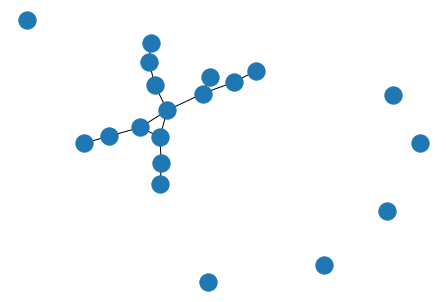

In [11]:
# Construction of the Erdos-Renyi model

p = 0.1
n = 20
W = np.zeros((n,n))

# fill the bottom-left block of W
for i in range(n):
    for j in range(i):
        W[i,j] = np.random.choice([0,1], p= [1-p,p])

# fill the top-right block
W = W + W.T
    
G = nx.from_numpy_array(W)

nx.draw(G)

With these parameters, the graph is typically disconnected, bacause the expected average degree is small. Let us increase $n$ while keeping $p$ constant.

Expected number of links: 1990.0
Number of links: 1983


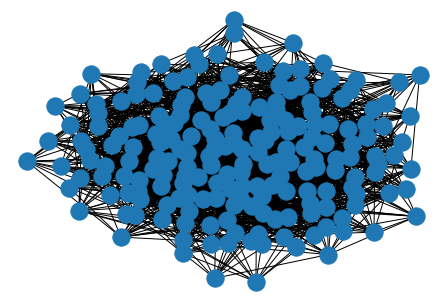

In [12]:
p = 0.1
n = 200
W = np.zeros((n,n))
W = W + W.T

for i in range(n):
    for j in range(i):
        W[i,j] = np.random.choice([0,1], p= [1-p,p])
    
G = nx.from_numpy_array(W, create_using=nx.Graph)

nx.draw(G)

print("Expected number of links:", p*n*(n-1)/2)
print("Number of links:", G.number_of_edges())

In [13]:
print("The graph is connected:", nx.is_connected(G))

The graph is connected: True


Now the plot of the graph is confusing, but the graph is connected.

This shows that $p$ is not a useful parameter to characterize the properties of an Erdos-Renyi graph, unless we specify $n$. In the next we shall consider cases in which $p$ is a function of $n$.

The problem of keeping $p$ fixed is that the expected average degree grows linearly with $n$, which is quite unrealistic. In fact, typically real networks are sparse.

We study two regimes of interest: $p \propto log(n)/n$ (average degree scaling with $log(n)$ and $p \propto 1/n$ (constant average degree).

### Case 2: $p = a \frac{log(n)}{n}$

Let us generate a large network and count the number of isolated nodes as a first connectivity measure. As we have seen before, if $p$ is fixed and $n$ increases the connectivity of the graph increases. Let us see if this changes when $p$ scales with $n$.

In [14]:
a = 2
n = 100
p = a*np.log(n)/n

W = np.zeros((n,n))

for i in range(n):
    for j in range(i):
        W[i,j] = np.random.choice([0,1], p= [1-p,p])
        
W = W + W.T
degree = W @ np.ones(n)

nodes_zero_degree = len(degree[degree == 0.])

print("Number of isolated nodes:", nodes_zero_degree)

Number of isolated nodes: 0


Let us increase $n$

In [15]:
a = 2
n_vec = np.arange(100,1100,200)

for n in n_vec:
    
    p = a*np.log(n)/n
    W = np.zeros((n,n))

    for i in range(n):
        for j in range(i):
            W[i,j] = np.random.choice([0,1], p= [1-p,p])

    W = W + W.T
    degree = W @ np.ones(n)
    
    nodes_zero_degree = len(degree[degree == 0.])
    
    print("n:", n)
    print("Number of isolated nodes:", nodes_zero_degree, "\n")

n: 100
Number of isolated nodes: 0 

n: 300
Number of isolated nodes: 0 

n: 500
Number of isolated nodes: 0 

n: 700
Number of isolated nodes: 0 

n: 900
Number of isolated nodes: 0 



Let us now try different values of $a$ while keeping $n$ fixed.

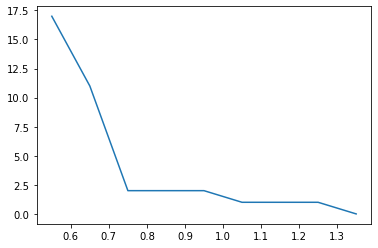

In [16]:
a_vec = np.arange(0.55,1.45,0.1)

nodes_zero_degree = []

for a in a_vec:
    n = 600
    p = a*np.log(n)/n

    W = np.zeros((n,n))

    for i in range(n):
        for j in range(i):
            W[i,j] = np.random.choice([0,1], p= [1-p,p])

    W = W + W.T
    degree = W @ np.ones(n)

    nodes_zero_degree.append(len(degree[degree == 0.]))
    
plt.plot(list(a_vec), nodes_zero_degree)

As expected, as $a$ increases the connectivity of the graph increases and the number of isolated nodes decreases.

In fact, one can prove that a phase transition occurs as $a$ varies.

The probability that a node is isolated is $(1-p)^{n-1}$. Thus, the number of isolated nodes in expectation is

$$
E[N_0] = \sum_{i} (1-p)^{n-1} = n(1-p)^{n-1}.
$$

If $p$ is a constant, as $n \to +\infty$ we get $E[N_0] \to 0$.

Instead one can show that if $p = a \frac{log{n}}{n}$, then $E[N_0] \to n^{1-a}$ as $n \to +\infty$, which means that:

- if $a > 1$, $E[N_0] = 0$;
- if $a < 1$, $E[N_0] = +\infty$.

The number of isolated nodes is a measure of connectivity of the graph. Another interesting question is whether the graph is connected or not.

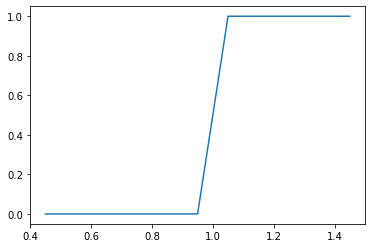

In [17]:
a_vec = np.arange(0.45,1.55,0.1)

is_connected = []

for a in a_vec:
    # generate the random graph
    n = 600
    p = a*np.log(n)/n

    W = np.zeros((n,n))

    for i in range(n):
        for j in range(i):
            W[i,j] = np.random.choice([0,1], p= [1-p,p])

    W = W + W.T
    G = nx.from_numpy_array(W, create_using=nx.Graph)
    # check whether is connected or not
    is_connected.append(nx.is_connected(G))
    
plt.plot(list(a_vec), is_connected)

One can prove that, as $n \to +\infty$, with large probability:
- if $a>1$, the graph is connected;
- if $a<1$, the graph is not connected.

It can also be proven that the diameter of the graph scales with $log(n)$.

### Case 3: $p = \frac{\lambda}{n}$.

While in case of constant $p$ and $p \propto \frac{log(n)}{n}$ the average degree of the nodes diverges as $n$ grows, here the average degree remains bounded. One can show that the degree distribution follows a Poisson distribution, i.e.,

$$
p_k := \frac{1}{n}|\{i: w_i = k\}| = e^{-\lambda}\frac{\lambda^k}{k!}
$$

In this case the graph is with probability 1 disconnected as $n \to +infty$. Still, there is another phase transition occurring regarding the size of the largest connected component. Specifically, as $n \to +infty$:

- if $\lambda<1$, then the size of each connected component i satisfies with probability 1 $C_i \le A log(n)$, i.e., each connected component contains a vanishing fraction of the total number of ndoes;
- if $\lambda>1$, with probability one the largest component has size $C_{max} = n(1-x)$, where $x$ solves $x = e^{\lambda(x-1)}$. Moreover, the size of the second largest component scales with $log(n)$.

The last property is proved by showing that an Erdos-Renyi graph is locally tree-like (i.e., there are no short cycles) and using results from branching processes.

Text(0.5, 0, 'Degree ER')

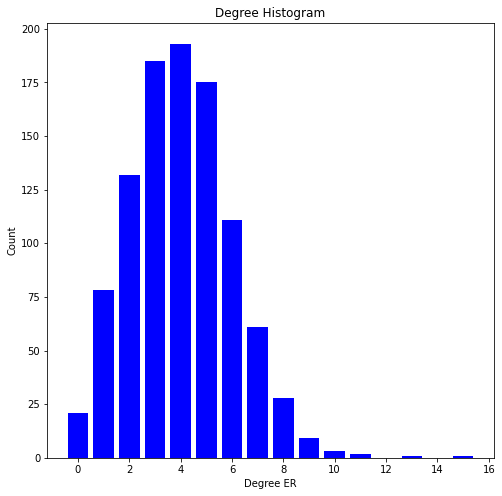

In [18]:
import collections 

a = 4
n = 1000
p = a/n

W = np.zeros((n,n))

for i in range(n):
    for j in range(i):
        W[i,j] = np.random.choice([0,1], p= [1-p,p])

W = W + W.T
G = nx.from_numpy_array(W, create_using=nx.Graph)

degree = W @ np.ones(n)
degreeCount = collections.Counter(degree)
deg, cnt = zip(*degreeCount.items())

fig = plt.figure(figsize=(8,8))
plt.bar(deg, cnt, width=0.80, color="b")
plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree ER")

Notice that the degree distribution is first increasing and then decreasing, meaning that a large fraction of the nodes has a degree close to the expected average degree, thus the average degree is a good approximation for the degree of a random node of the graph. The variance of the degree distribution is "small".

We shall see in the next lecture that in real networks, as well as other random graphs (e.g., preferential attachment), the variance of the degree distribution is large, i.e., there are a few nodes with very large degree and many nodes with a small degree (compared to average degree).

We finally compute the **clustering coefficient** of the graph, which is the number of triangles in the graph.

In terms of social networks, clustering coefficient in some sense describes "how many friends of a given node are friends".

We expect that clustering coefficient in ER graph is small. Indeed, because of the random structure of the connections there is no reason to expect triangles in the graph.

In [19]:
clustering_ER = nx.average_clustering(G)

print("Clustering coefficient in ER graph:", clustering_ER)

Clustering coefficient in ER graph: 0.004666666666666667


## Small world networks

Small world networks are characterized by two features:

- small diameter (sublinear in $n$);
- large clustering coefficient (i.e., number of triangles in the graph).

For the range of parameters $(n,p)$ that make the graph connected, ER graphs satisfy the first condition (the diameter scales with $log(n)$), but not the second one.

Let us see how to generate a small world network. An example is as follows. We start with the following augmented ring.

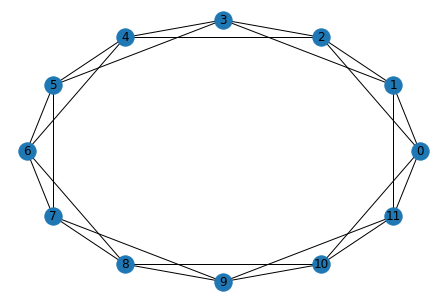

In [20]:
n_nodes = 12

G = nx.cycle_graph(n_nodes)

for n in range(n_nodes):
    G.add_edge(n,((n+2) % n_nodes))
    G.add_edge(n,((n-2) % n_nodes))

pos = nx.circular_layout(G)

nx.draw(G,pos,with_labels=True)

Let us generate a larger graphs like this, and investigate clustering coefficient and diameter.

In [21]:
n_nodes_vec = [40,80,160,320,640]

for n_nodes in n_nodes_vec:
    G = nx.cycle_graph(n_nodes)

    for n in range(n_nodes):
        G.add_edge(n,((n+2) % n_nodes))
        G.add_edge(n,((n-2) % n_nodes))

    print("n:", n_nodes)
    print("diameter", nx.diameter(G))
    print("clustering coefficient", nx.average_clustering(G), "\n")

n: 40
diameter 10
clustering coefficient 0.5 

n: 80
diameter 20
clustering coefficient 0.5 

n: 160
diameter 40
clustering coefficient 0.5 

n: 320
diameter 80
clustering coefficient 0.5 

n: 640
diameter 160
clustering coefficient 0.5 



Two observations:
- the clustering coefficient is large and does not scale with $n$;
- the diameter scales linearly with $n$.

To reduce the diameter and obtain a small world network, it is sufficient to add some random 'long distance' connections.

In [22]:
p = 0.002
n_nodes = 640

G = nx.cycle_graph(n_nodes)

for n in range(n_nodes):
    G.add_edge(n,((n+2) % n_nodes))
    G.add_edge(n,((n-2) % n_nodes))

for i in range(n_nodes):
    for j in range(n_nodes):
        if np.random.rand() < p:
            G.add_edge(i,j)
            
print("Diameter:", nx.diameter(G))
print("Clustering coefficient", nx.average_clustering(G), "\n")

Diameter: 7
Clustering coefficient 0.20541328463203445 



The new graph has a small diameter. The clustering coefficient is reduced, but still much larger than in Erdos-Renyi graph.

Still, the degree distribution is a shifted Poisson distribution, which differs from the most of the real networks.